<a href="https://colab.research.google.com/github/Kanaieu/deteksi-7-bunga-cnn/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [7 Spesies Bunga](https://www.kaggle.com/datasets/nadyana/flowers/data)
- **Nama:** Muhammad Tsaqiif Ash-Shiddiq
- **Email:** muhammadtsaqiif.ash@gmail.com
- **ID Dicoding:** muhammadtsaqiifash

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadtsaqiifa","key":"1572ef8a163b81d1b96bbe808a6d053f"}'}

In [5]:
!rm -rf flowers/

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d nadyana/flowers
!unzip flowers.zip

Streaming output truncated to the last 5000 lines.
  inflating: flowers/lotus/lotusnvevin.jpg  
  inflating: flowers/lotus/louts-flower-pond-close-up-petals-stamin-lotus-lily-144696984.jpg  
  inflating: flowers/lotus/macro-lotus-flower-13214393.jpg  
  inflating: flowers/lotus/macro-pink-lotus-flower-macro-pink-lotus-flower-close-up-pink-lotus-flower-raining-sunlight-morning-159065830.jpg  
  inflating: flowers/lotus/maxresdefault1.jpg  
  inflating: flowers/lotus/micro_-shot_-of_-a_-white_-lotus_-flower_-micro_-shot_-of_-a_-white_-lotus_-flower_-with_-green_-159427226.jpg  
  inflating: flowers/lotus/national_flower_inner.jpg  
  inflating: flowers/lotus/ndsfgiw.png  
  inflating: flowers/lotus/nelumbo-nucifera-flower-also-known-as-indian-lotus-sacred-lotus-bean-india-egyptian-bean-simply-lotus-nelumbo-nucifera-143764558.jpg  
  inflating: flowers/lotus/nelumbo_2.jpg  
  inflating: flowers/lotus/nlevnwoejr.jpg  
  inflating: flowers/lotus/p9ihfe5f.png  
  inflating: flowers/lotus/pex

**Plot gambar sampel untuk semua kelas**

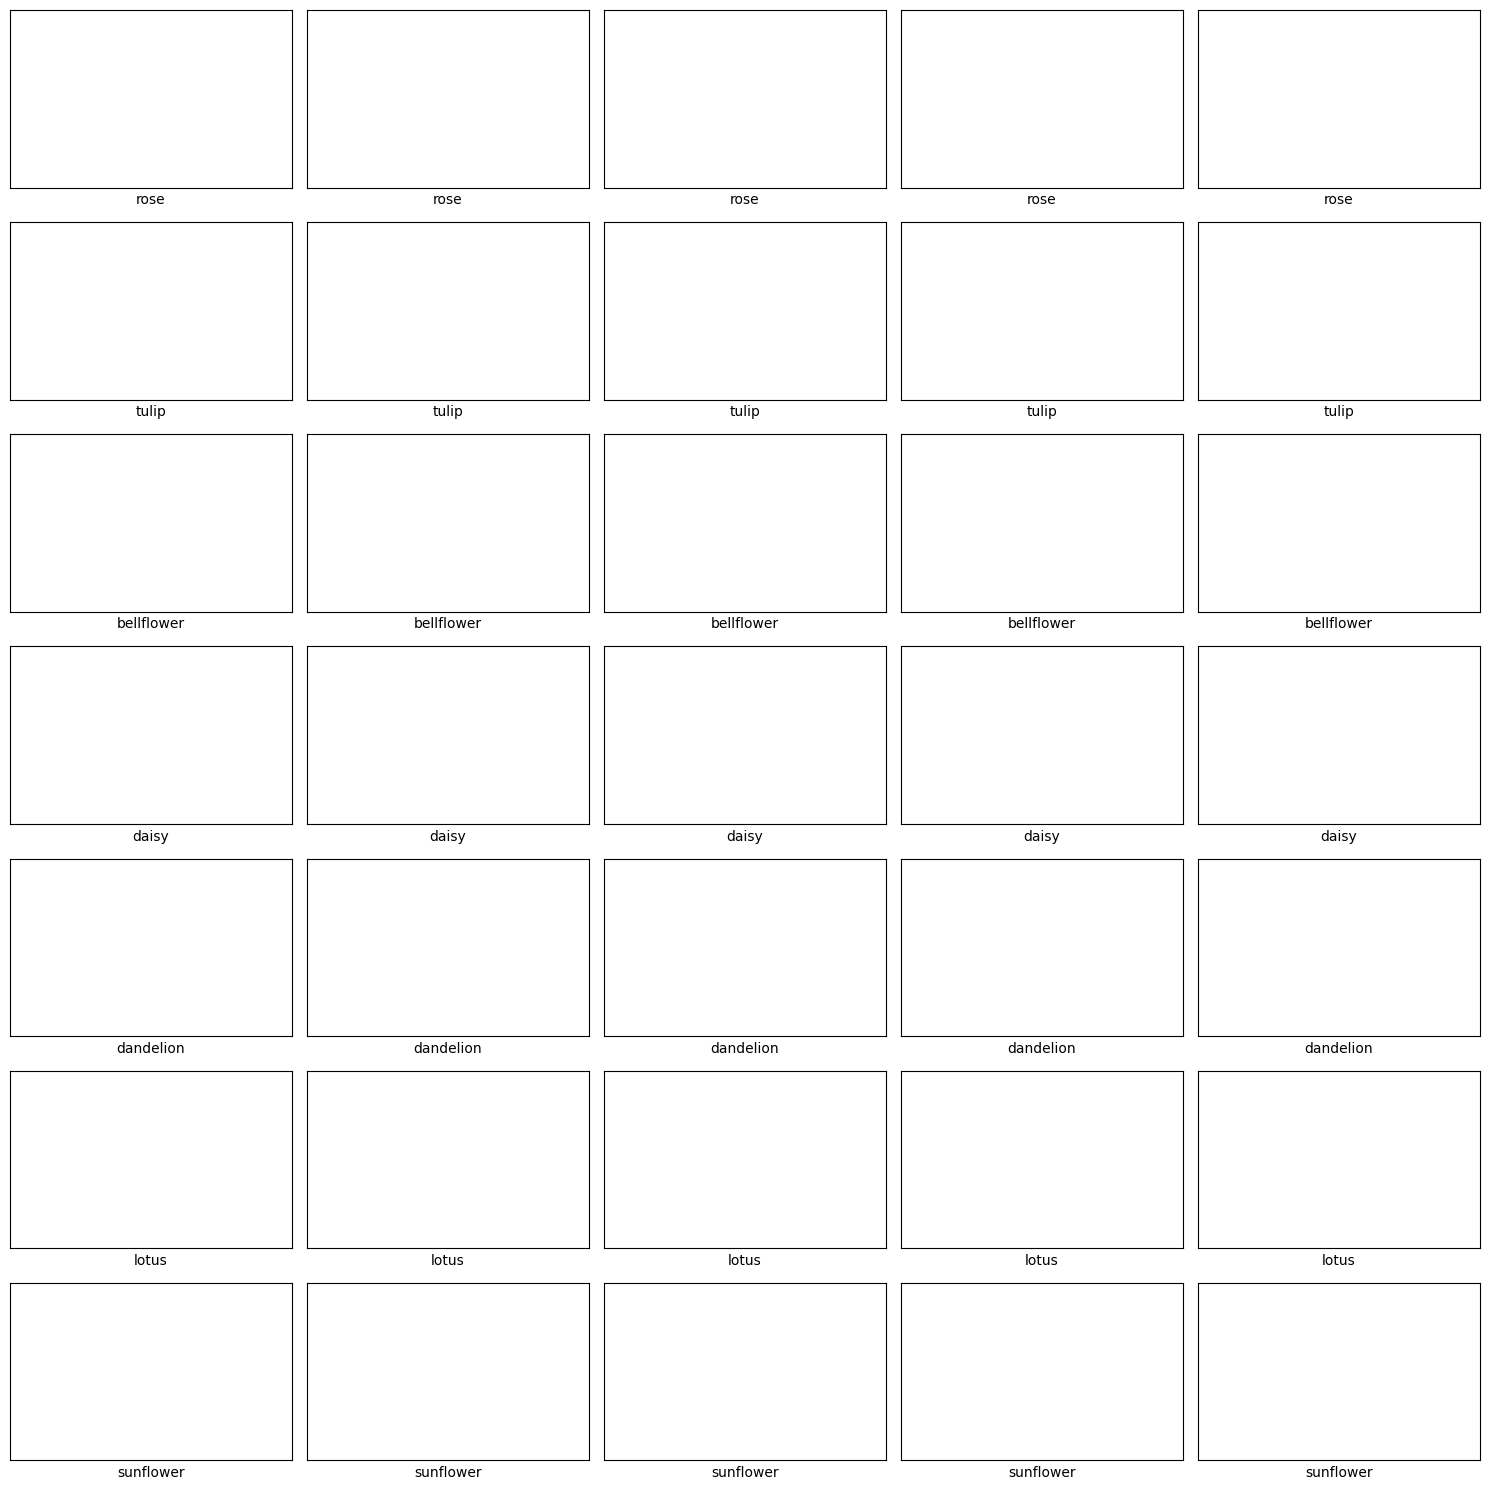

In [8]:
lung_image = {}

path = "flowers/"
for i in os.listdir(path):
    lung_image[i] = os.listdir(os.path.join(path, i))

fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

**Plot distribusi gambar di seluruh kelas**

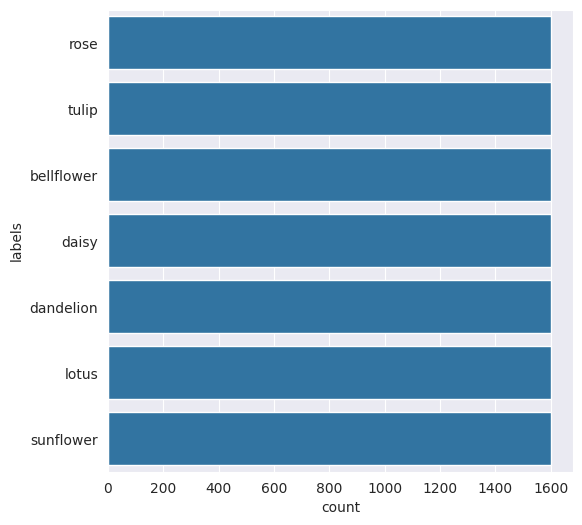

In [9]:
lung_path = "flowers/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [10]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'flowers/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

,0
labels,
bellflower,1600
daisy,1600
dandelion,1600
lotus,1600
rose,1600
sunflower,1600
tulip,1600


In [11]:
X= df['path']
y= df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Menggunakan Stratify agar penyebaran seimbang**

In [12]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

print('train size', len(df_tr))
print('test size', len(df_te))

train size 8960
test size 2240


In [13]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels    
test   bellflower     320
       daisy          320
       dandelion      320
       lotus          320
       rose           320
       sunflower      320
       tulip          320
train  bellflower    1280
       daisy         1280
       dandelion     1280
       lotus         1280
       rose          1280
       sunflower     1280
       tulip         1280
dtype: int64 


                                                   path labels    set
3451          flowers/rose/14747962886_2bff6bb323_m.jpg   rose  train
7410                        flowers/lotus/GS_0_9457.png  lotus  train
8383  flowers/tulip/6b4abeb00bb1364dfd94f0c264edcf0c...  tulip  train
5684                        flowers/lotus/GS_0_8647.png  lotus  train
2305     flowers/lotus/National-Flower-ili-70-ogimg.jpg  lotus  train


In [14]:
datasource_path = "flowers/"
dataset_path = "Dataset-Final/"

In [15]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

#### Image Data Generator

In [16]:
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_bellflower = os.path.join(TRAIN_DIR, 'bellflower')
train_daisy = os.path.join(TRAIN_DIR, 'daisy')
train_dandelion = os.path.join(TRAIN_DIR, 'dandelion')
train_lotus = os.path.join(TRAIN_DIR, 'lotus')
train_rose = os.path.join(TRAIN_DIR, 'rose')
train_sunflower = os.path.join(TRAIN_DIR, 'sunflower')
train_tulip = os.path.join(TRAIN_DIR, 'tulip')

test_bellflower = os.path.join(TEST_DIR, 'bellflower')
test_daisy = os.path.join(TEST_DIR, 'daisy')
test_dandelion = os.path.join(TEST_DIR, 'dandelion')
test_lotus = os.path.join(TEST_DIR, 'lotus')
test_rose = os.path.join(TEST_DIR, 'rose')
test_sunflower = os.path.join(TEST_DIR, 'sunflower')
test_tulip = os.path.join(TEST_DIR, 'tulip')

print("Total number of bellflower images in training set: ", len(os.listdir(train_bellflower)))
print("Total number of daisy images in training set: ", len(os.listdir(train_daisy)))
print("Total number of dandelion images in training set: ", len(os.listdir(train_dandelion)))
print("Total number of lotus images in training set: ", len(os.listdir(train_lotus)))
print("Total number of rose images in training set: ", len(os.listdir(train_rose)))
print("Total number of sunflower images in training set: ", len(os.listdir(train_sunflower)))
print("Total number of tulips images in training set: ", len(os.listdir(train_tulip)))

print("Total number of bellflower images in test set: ", len(os.listdir(test_bellflower)))
print("Total number of daisy images in test set: ", len(os.listdir(test_daisy)))
print("Total number of dandelion images in test set: ", len(os.listdir(test_dandelion)))
print("Total number of lotus images in test set: ", len(os.listdir(test_lotus)))
print("Total number of rose images in test set: ", len(os.listdir(test_rose)))
print("Total number of sunflower images in test set: ", len(os.listdir(test_sunflower)))
print("Total number of tulips images in test set: ", len(os.listdir(test_tulip)))

Total number of bellflower images in training set:  1280
Total number of daisy images in training set:  1280
Total number of dandelion images in training set:  1280
Total number of lotus images in training set:  1280
Total number of rose images in training set:  1280
Total number of sunflower images in training set:  1280
Total number of tulips images in training set:  1280
Total number of bellflower images in test set:  320
Total number of daisy images in test set:  320
Total number of dandelion images in test set:  320
Total number of lotus images in test set:  320
Total number of rose images in test set:  320
Total number of sunflower images in test set:  320
Total number of tulips images in test set:  320


In [17]:
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=10,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=16,
    subset='training',
    class_mode='sparse',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=16,
    subset='validation',
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=1,
    class_mode='sparse',
    subset=None,
    shuffle=False
)

Found 7168 images belonging to 7 classes.
Found 1792 images belonging to 7 classes.
Found 2240 images belonging to 7 classes.


## Modelling

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout

In [19]:
from tensorflow.keras import regularizers
model_32 = Sequential([
    # 1st Convolutional Block
    # Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3), kernel_regularizer=regularizers.l2(0.0005))
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # 2nd Convolutional Block
    Conv2D(32, (4, 4), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # 3rd Convolutional Block
    Conv2D(32, (7, 7), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    # Flatten layer
    Flatten(),

    # Dense + Dropout layers
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)),
    Dropout(0.3),

    # Output layer
    Dense(7, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model_32.compile(optimizer=tf.keras.optimizers.Adam(0.00003),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [21]:
print(model_32.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,288,007 (12.54 MB)

 Trainable params: 3,287,815 (12.54 MB)

 Non-trainable params: 192 (768.00 B)

None


In [22]:
class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, monitor='val_accuracy', target=0.85, patience=5):
        super(EarlyStoppingAtAccuracy, self).__init__()
        self.monitor = monitor
        self.target = target
        self.patience = patience
        self.wait = 0
        self.stopping_triggered = False

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)

        if current is None:
            return

        if current >= self.target:
            if not self.stopping_triggered:
                self.stopping_triggered = True
                self.wait = 0

            else:
                if self.wait >= self.patience:
                    self.model.stop_training = True
                    print(f"\nStopping training: {self.monitor} sudah >= {self.target} dan patience {self.patience} habis.")
                self.wait += 1
        else:
            self.wait = 0

In [28]:
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_accuracy = EarlyStoppingAtAccuracy(monitor='val_accuracy', target=0.85, patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_lr=1e-6)

In [ ]:
history_32 = model_32.fit(
    train_generator,
    epochs=30,
    batch_size=16,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback, early_stopping_accuracy, reduce_lr]
)

Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8149 - loss: 1.0680
Epoch 1: val_accuracy improved from -inf to 0.80134, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 122s 271ms/step - accuracy: 0.8149 - loss: 1.0680 - val_accuracy: 0.8013 - val_loss: 1.0995 - learning_rate: 1.0000e-04
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8137 - loss: 1.0909
Epoch 2: val_accuracy improved from 0.80134 to 0.82031, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 119s 266ms/step - accuracy: 0.8137 - loss: 1.0909 - val_accuracy: 0.8203 - val_loss: 1.0547 - learning_rate: 1.0000e-04
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8259 - loss: 1.0250
Epoch 3: val_accuracy did not improve from 0.82031
448/448 ━━━━━━━━━━━━━━━━━━━━ 118s 264ms/step - accuracy: 0.8259 - loss: 1.0250 - val_accuracy: 0.7885 - val_loss: 1.1167 - learning_rate: 1.0000e-04
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8249 - loss: 1.0333
Epoch 4: val_accuracy did not improve from 0.82031
448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 267ms/step - accuracy: 0.8249 - loss: 1.0334 - val_accuracy: 0.8142 - val_loss: 1.1007 - learning_rate: 1.0000e-04
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8230 - loss: 1.0304
Epoch 5: val_accuracy did not improve from 0.82031

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
448/448 ━━━━━━━━━━━━━━━━━━━━ 117s 261ms/step - accuracy: 0

448/448 ━━━━━━━━━━━━━━━━━━━━ 119s 266ms/step - accuracy: 0.8467 - loss: 0.9554 - val_accuracy: 0.8309 - val_loss: 0.9994 - learning_rate: 2.0000e-05
Epoch 7/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8453 - loss: 0.9417
Epoch 7: val_accuracy improved from 0.83092 to 0.83984, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 118s 264ms/step - accuracy: 0.8453 - loss: 0.9417 - val_accuracy: 0.8398 - val_loss: 0.9786 - learning_rate: 2.0000e-05
Epoch 8/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8573 - loss: 0.9157
Epoch 8: val_accuracy did not improve from 0.83984
448/448 ━━━━━━━━━━━━━━━━━━━━ 118s 265ms/step - accuracy: 0.8573 - loss: 0.9157 - val_accuracy: 0.8382 - val_loss: 0.9735 - learning_rate: 2.0000e-05
Epoch 9/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8525 - loss: 0.9141
Epoch 9: val_accuracy did not improve from 0.83984
448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 267ms/step - accuracy: 0.8525 - loss: 0.9141 - val_accuracy: 0.8387 - val_loss: 0.9615 - learning_rate: 2.0000e-05
Epoch 10/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8669 - loss: 0.8809
Epoch 10: val_accuracy did not improve from 0.83984
448/448 ━━━━━━━━━━━━━━━━━━━━ 119s 266ms/step - accuracy: 0.8669 - loss: 0.8809 - val_accuracy: 0.8365 - val_loss: 0.9360 - learning_ra

448/448 ━━━━━━━━━━━━━━━━━━━━ 119s 265ms/step - accuracy: 0.8675 - loss: 0.8552 - val_accuracy: 0.8415 - val_loss: 0.9449 - learning_rate: 2.0000e-05
Epoch 12/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8719 - loss: 0.8420
Epoch 12: val_accuracy did not improve from 0.84152
448/448 ━━━━━━━━━━━━━━━━━━━━ 119s 265ms/step - accuracy: 0.8719 - loss: 0.8420 - val_accuracy: 0.8315 - val_loss: 0.9396 - learning_rate: 2.0000e-05
Epoch 13/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8739 - loss: 0.8457
Epoch 13: val_accuracy improved from 0.84152 to 0.84710, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 267ms/step - accuracy: 0.8739 - loss: 0.8457 - val_accuracy: 0.8471 - val_loss: 0.9276 - learning_rate: 2.0000e-05
Epoch 14/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8701 - loss: 0.8262
Epoch 14: val_accuracy improved from 0.84710 to 0.84821, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 268ms/step - accuracy: 0.8701 - loss: 0.8262 - val_accuracy: 0.8482 - val_loss: 0.8988 - learning_rate: 2.0000e-05
Epoch 15/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8755 - loss: 0.8181
Epoch 15: val_accuracy did not improve from 0.84821
448/448 ━━━━━━━━━━━━━━━━━━━━ 122s 272ms/step - accuracy: 0.8755 - loss: 0.8181 - val_accuracy: 0.8449 - val_loss: 0.9083 - learning_rate: 2.0000e-05
Epoch 16/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8738 - loss: 0.8044
Epoch 16: val_accuracy did not improve from 0.84821
448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 268ms/step - accuracy: 0.8738 - loss: 0.8045 - val_accuracy: 0.8276 - val_loss: 0.9198 - learning_rate: 2.0000e-05
Epoch 17/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8717 - loss: 0.8156
Epoch 17: val_accuracy did not improve from 0.84821
448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 268ms/step - accuracy: 0.8717 - loss: 0.8156 - val_accuracy: 0.8460 - val_loss: 0.8870 - learnin

448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 268ms/step - accuracy: 0.8630 - loss: 0.8199 - val_accuracy: 0.8516 - val_loss: 0.8871 - learning_rate: 2.0000e-05
Epoch 19/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8856 - loss: 0.7845
Epoch 19: val_accuracy did not improve from 0.85156
448/448 ━━━━━━━━━━━━━━━━━━━━ 119s 265ms/step - accuracy: 0.8856 - loss: 0.7845 - val_accuracy: 0.8398 - val_loss: 0.8914 - learning_rate: 2.0000e-05
Epoch 20/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8765 - loss: 0.7831
Epoch 20: val_accuracy did not improve from 0.85156

Epoch 20: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
448/448 ━━━━━━━━━━━━━━━━━━━━ 118s 263ms/step - accuracy: 0.8766 - loss: 0.7831 - val_accuracy: 0.8371 - val_loss: 0.8986 - learning_rate: 2.0000e-05
Epoch 21/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8840 - loss: 0.7478
Epoch 21: val_accuracy improved from 0.85156 to 0.85379, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 119s 266ms/step - accuracy: 0.8840 - loss: 0.7478 - val_accuracy: 0.8538 - val_loss: 0.8710 - learning_rate: 4.0000e-06
Epoch 22/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8811 - loss: 0.7782
Epoch 22: val_accuracy did not improve from 0.85379
448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 267ms/step - accuracy: 0.8811 - loss: 0.7781 - val_accuracy: 0.8482 - val_loss: 0.8761 - learning_rate: 4.0000e-06
Epoch 23/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8820 - loss: 0.7477
Epoch 23: val_accuracy did not improve from 0.85379
448/448 ━━━━━━━━━━━━━━━━━━━━ 145s 273ms/step - accuracy: 0.8820 - loss: 0.7477 - val_accuracy: 0.8465 - val_loss: 0.8685 - learning_rate: 4.0000e-06
Epoch 24/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8824 - loss: 0.7491
Epoch 24: val_accuracy improved from 0.85379 to 0.85491, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 121s 270ms/step - accuracy: 0.8825 - loss: 0.7491 - val_accuracy: 0.8549 - val_loss: 0.8617 - learning_rate: 4.0000e-06
Epoch 25/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8863 - loss: 0.7388
Epoch 25: val_accuracy improved from 0.85491 to 0.85603, saving model to best_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 140s 266ms/step - accuracy: 0.8863 - loss: 0.7388 - val_accuracy: 0.8560 - val_loss: 0.8463 - learning_rate: 4.0000e-06
Epoch 26/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8959 - loss: 0.7270
Epoch 26: val_accuracy did not improve from 0.85603
448/448 ━━━━━━━━━━━━━━━━━━━━ 120s 267ms/step - accuracy: 0.8959 - loss: 0.7270 - val_accuracy: 0.8477 - val_loss: 0.8803 - learning_rate: 4.0000e-06
Epoch 27/30
 26/448 ━━━━━━━━━━━━━━━━━━━━ 1:27 208ms/step - accuracy: 0.8901 - loss: 0.7848

## Evaluasi dan Visualisasi

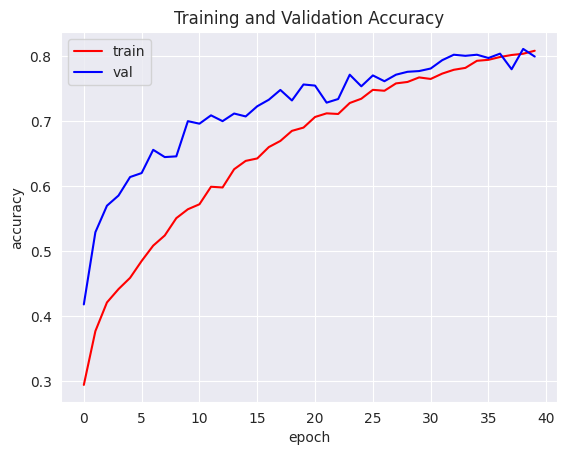

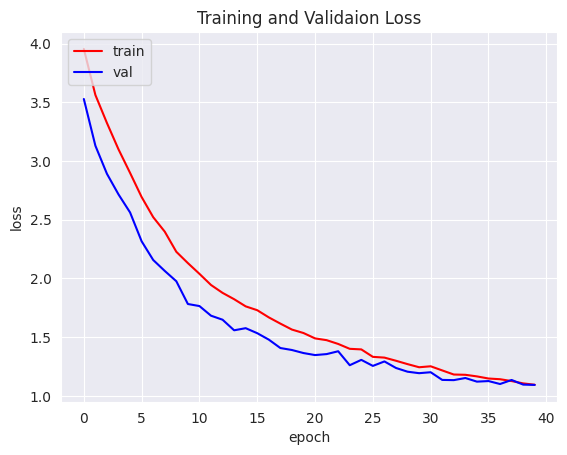

In [25]:
acc = history_32.history['accuracy']
val_acc = history_32.history['val_accuracy']
loss = history_32.history['loss']
val_loss = history_32.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

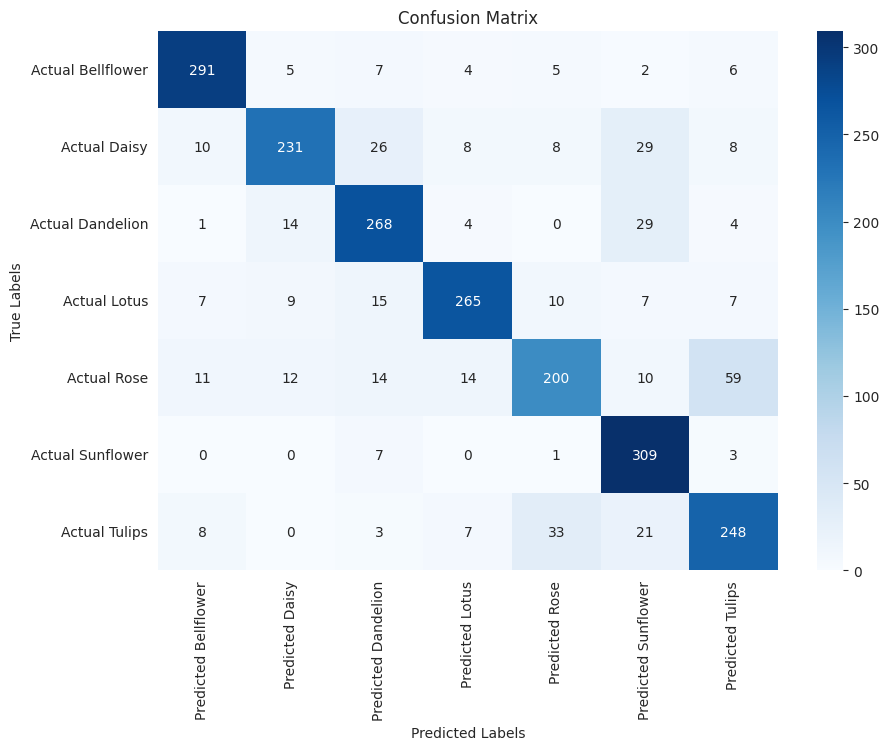



              precision    recall  f1-score   support

  bellflower     0.8872    0.9094    0.8981       320
       daisy     0.8524    0.7219    0.7817       320
   dandelion     0.7882    0.8375    0.8121       320
       lotus     0.8775    0.8281    0.8521       320
        rose     0.7782    0.6250    0.6932       320
   sunflower     0.7592    0.9656    0.8501       320
      tulips     0.7403    0.7750    0.7573       320

    accuracy                         0.8089      2240
   macro avg     0.8119    0.8089    0.8064      2240
weighted avg     0.8119    0.8089    0.8064      2240



In [26]:
test_generator.reset()

preds_1 = model_32.predict(test_generator, verbose=0)
preds_1 = np.argmax(preds_1, axis=1)
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1),
                  index=["Actual Bellflower", "Actual Daisy", "Actual Dandelion", "Actual Lotus", "Actual Rose", "Actual Sunflower", "Actual Tulips"],
                  columns=["Predicted Bellflower", "Predicted Daisy", "Predicted Dandelion", "Predicted Lotus", "Predicted Rose", "Predicted Sunflower", "Predicted Tulips"])

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("\n")
print(classification_report(y_true=test_generator.classes,
                            y_pred=preds_1,
                            target_names=['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulips'],
                            digits=4))

## Konversi Model

**savedmodel**

In [27]:
model_32.save("/content/saved_model")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/saved_model.

**TensorFlow Lite**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_32)
tflite_model = converter.convert()

with open("/content/tflite/model_32.tflite", "wb") as f:
    f.write(tflite_model)

**TensorFlow.js**

In [ ]:
tfjs.converters.save_keras_model(model_32, "/content/tfjs_model")

## Inference (Optional)

In [ ]:
model_path = '/content/saved_model'
model = tf.keras.models.load_model(model_path)

In [ ]:
img_path = 'flowers/bellflower/0.jpg'
img = tf.keras.preprocessing.image.load_img(img_path)
img_array = tf.keras.preprocessing.image.img_to_array(img)

img_array_resized = resize_with_padding(img_array, 150, 150)
img_array_resized = img_array_resized / 255.0

img_array_resized = tf.expand_dims(img_array_resized, axis=0)

predictions = model_1.predict(img_array_resized)
print(predictions)